# Clustering Metric

This notebook will try to come up with some clustering metric such that we can determine if the dots are truley random or have some clustering structure.

Start with background thresh
Then with deconvolution
then further thresh for binarization
then morphological operations on this to close any gaps 


then spatial cluster the near bloc based on k-means. take the spatial location of each point with its

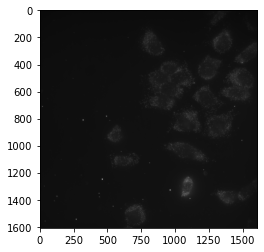

In [20]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndi
import skimage.io as skio
import skimage.measure as skmeasure
import skimage.morphology as skmorph
import matplotlib.pyplot as plt
import astropy.stats as apstats

import warnings

warnings.filterwarnings('ignore')
import sys 
sys.path.append("/Users/shaider/merfish_code/exp_img_reports")

import utils.imgproc as helpers

img = skio.imread('/Users/shaider/Downloads/1hrs_647.TIFF')
plt.imshow(img,cmap='gray',vmin=0)
plt.show()

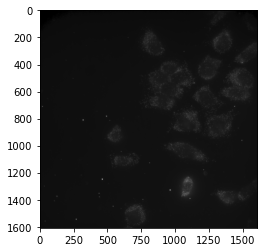

In [21]:
background_thresh = 3000

img_bgthresh = np.where(img>background_thresh,img,0)
plt.imshow(img_bgthresh,cmap='gray',vmin=0)
plt.show()


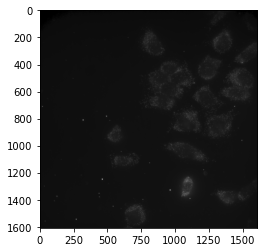

In [22]:
psf = None

img_deconvolve = img_bgthresh#helpers.deconvolve_img(img_bgthresh,psf)
plt.imshow(img_deconvolve,cmap='gray',vmin=0)
plt.show()

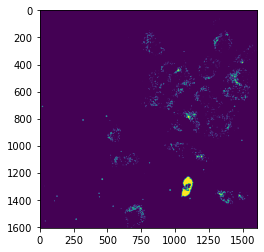

In [23]:

percentile = 99

binary_thresh = np.percentile(img_deconvolve,percentile)

img_binarised = np.where(img_deconvolve>binary_thresh,1,0)

plt.imshow(img_binarised)
plt.show()

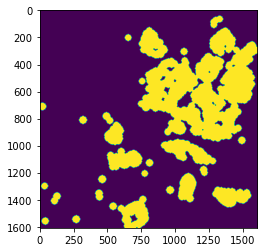

In [24]:
opening_rounds = 10
opening_selem = skmorph.disk(radius =3)


img_morphed = img_binarised.copy()


for _ in range(opening_rounds):
    img_morphed = skmorph.binary_dilation(img_morphed,selem=opening_selem)

erosion_selem = skmorph.disk(radius = 3)
img_morphed = skmorph.binary_erosion(img_morphed,selem=erosion_selem)


plt.imshow(img_morphed)
plt.show()

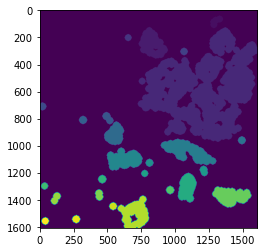

In [25]:
img_labelled = skmeasure.label(img_morphed)
plt.imshow(img_labelled)
plt.show()

26


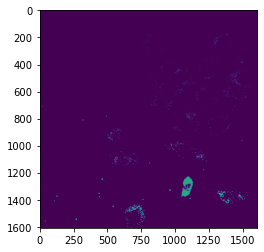

In [26]:
img_label_groups = np.multiply(img_labelled,img_binarised)
num_groups = img_label_groups.max()

print(num_groups)
plt.imshow(img_label_groups)
plt.show()

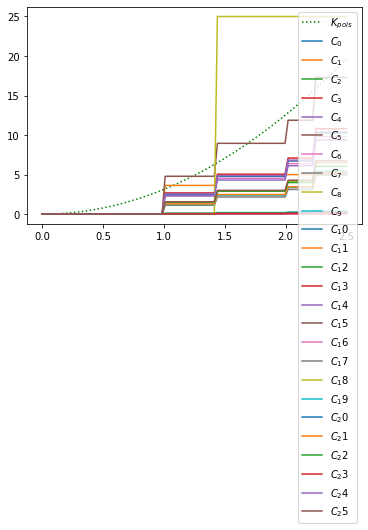

In [27]:
#for each label, get the x-y coords, then run it through the astropy kestimator
r = np.linspace(0, 2.5, 100)

Kest = apstats.RipleysKEstimator(area=25)

f,ax = plt.subplots()
plt.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
for c in range(num_groups):
    group_img = np.where(img_label_groups==c,img_label_groups,0)
    data_pts = np.transpose(np.nonzero(group_img))
    plt.plot(r, Kest(data=data_pts, radii=r, mode='none'),
         label=fr'$C_{c}$')

plt.legend()
plt.show()